<a href="https://colab.research.google.com/github/tekliyetamiru/Fake-News-Detections-By-Using-DistilBERT-MobileBERT-and-TinyBERT-Model/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection**

In [2]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U Umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')


## **Data Loading**

In [3]:
import pandas as pd

datafile = pd.read_excel("https://github.com/tekliyetamiru/Fake-News-Detections-By-Using-DistilBERT-MobileBERT-and-TinyBERT-Model/raw/main/fake_news.xlsx")
datafile.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
datafile.isnull().sum()

,0
id,0
title,558
author,1957
text,43
label,0


In [5]:
datafile = datafile.dropna()
datafile.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [6]:
datafile['label'].value_counts()

,count
label,
0,10361
1,7920


## **Dataset Analysis**

In [7]:
import matplotlib.pyplot as plt


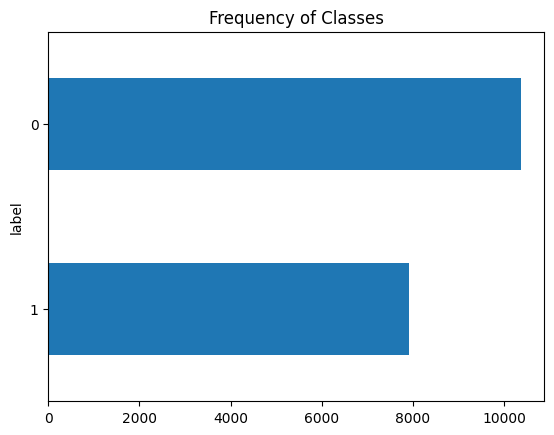

In [8]:
label_counts = datafile['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

Text(0.5, 1.0, 'Text Tokens')

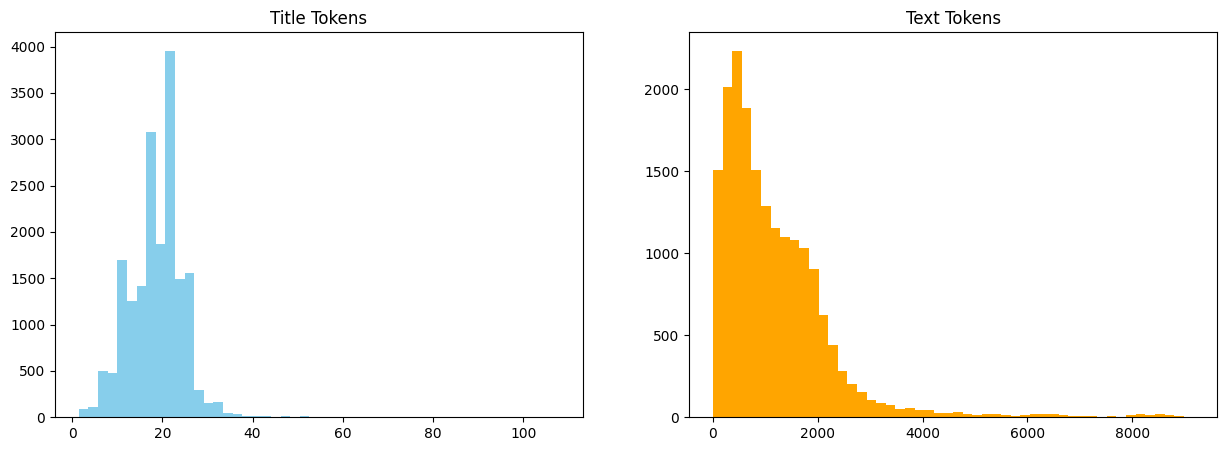

In [9]:
# 1.5 tokens per word on average

datafile['title_tokens'] = datafile['title'].apply(lambda x: len(x.split())*1.5)
datafile['text_tokens'] = datafile['text'].apply(lambda x: len(x.split())*1.5)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(datafile['title_tokens'], bins=50, color="skyblue")
ax[0].set_title("Title Tokens")

ax[1].hist(datafile['text_tokens'], bins=50, color="orange")
ax[1].set_title("Text Tokens")


### **Split Dataset into train and test**

In [10]:
from sklearn.model_selection import train_test_split

# 70% for traing, 20% for test and 10% for validation
train, test = train_test_split(datafile, test_size = 0.3, stratify=datafile['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

datafile.shape,train.shape, test.shape, validation.shape

((18281, 7), (12796, 7), (3656, 7), (1829, 7))

In [11]:
from datasets import Dataset, DatasetDict

dataset= DatasetDict({
    "train":Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation":Dataset.from_pandas(validation, preserve_index=False)
})

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

### **Data Tokenization**

In [13]:
from transformers import AutoTokenizer
text = "machine learning is awesome!! Thanks KG take."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [14]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [15]:
def tokenize(batch):
  temp = distilbert_tokenizer(batch['title'],padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 4584, 1024, 11865, 24917, 2038, 2085, 19450, 1015, 1013, 1017, 1997, 1996, 8484, 17401, 102, 0, 0, 0], [101, 4994, 1520, 2637, 2034, 1010, 1521, 2647, 3741, 13989, 2000, 2022, 2117, 1011, 1996, 2047, 2259, 2335, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [16]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## **Model Building**

In [17]:
from transformers import AutoModelForSequenceClassification,AutoConfig
import torch

label2id = {"Real":0,"Fake":1}
id2label = {0:"Real",1:"Fake"}


model_ckpt = "distilbert-base-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
# model_ckpt = "google/mobilebert-uncased"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.6",
  "vocab_size": 30522
}

## **Model Training**

In [19]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


In [20]:
# Build compute metrics function
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions,references=labels)

In [21]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False
)

In [22]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

In [24]:
trainer.train()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.235600
1000,0.165300
1500,0.144100
2000,0.085100
2500,0.071100
3000,0.087100
3500,0.038300
4000,0.028000
4500,0.023700


TrainOutput(global_step=4800, training_loss=0.09322324633598328, metrics={'train_runtime': 1621.6959, 'train_samples_per_second': 23.672, 'train_steps_per_second': 2.96, 'total_flos': 953467218676224.0, 'train_loss': 0.09322324633598328, 'epoch': 3.0})

## **Model Evaluation**

In [25]:
preds_output=trainer.predict(encoded_dataset['test'])

In [27]:
preds_output.metrics

{'test_loss': 0.19587746262550354,
 'test_accuracy': 0.9600656455142232,
 'test_runtime': 17.6303,
 'test_samples_per_second': 207.371,
 'test_steps_per_second': 25.921}

In [28]:
y_pred = np.argmax(preds_output.predictions,axis=1)
y_true = encoded_dataset['test'][:]['label']

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.97      0.96      0.96      2072
        Fake       0.95      0.96      0.95      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## **Benchmarking**

In [33]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels,preds,average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy":acc, "f1":f1}

In [38]:

model_dict={
    "bert-base":"bert-base-uncased",
    "distilbert":"distilbert-base-uncased",
    "mobilebert":"google/mobilebert-uncased",
    "tinybert":"huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
  model_ckpt=model_dict[model_name]
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id, id2label=id2label)
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

  def local_tokenizer(batch):
    temp = tokenizer(batch['title'],padding=True,truncation=True)
    return temp

  encoded_dataset=dataset.map(local_tokenizer,batched=True,batch_size=None)

  trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer
    )
  trainer.train()

  preds = trainer.predict(encoded_dataset['test'])

  return preds.metrics

import time
model_performance={}
for model_name in model_dict:
  print("\n\n")
  print("Training Model: ", model_name)

  start = time.time()
  result = train_model(model_name)
  end = time.time()
  model_performance[model_name] = {model_name:result,"time taken":end-start}




Training Model:  bert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.306200
1000,0.253500
1500,0.228100
2000,0.177600
2500,0.164600
3000,0.146400
3500,0.121900
4000,0.085400
4500,0.085600





Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.241300
1000,0.183200
1500,0.145700
2000,0.094000
2500,0.080900
3000,0.086500
3500,0.045500
4000,0.034000
4500,0.021900





Training Model:  mobilebert


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,40385.624000
1000,0.189900
1500,0.175300
2000,0.129700
2500,0.120400
3000,0.131000
3500,0.069600
4000,0.050200
4500,0.046300





Training Model:  tinybert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.305500
1000,0.215000
1500,0.202500
2000,0.140200
2500,0.133500
3000,0.143400
3500,0.107600
4000,0.100600
4500,0.079600


In [39]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.17025835812091827,
   'test_accuracy': 0.9595185995623632,
   'test_f1': 0.9595951925926608,
   'test_runtime': 16.0077,
   'test_samples_per_second': 228.39,
   'test_steps_per_second': 28.549},
  'time taken': 850.658088684082},
 'distilbert': {'distilbert': {'test_loss': 0.21281534433364868,
   'test_accuracy': 0.9597921225382933,
   'test_f1': 0.9597936139685054,
   'test_runtime': 8.288,
   'test_samples_per_second': 441.121,
   'test_steps_per_second': 55.14},
  'time taken': 457.31962490081787},
 'mobilebert': {'mobilebert': {'test_loss': 0.23240521550178528,
   'test_accuracy': 0.9578774617067833,
   'test_f1': 0.9578310050108503,
   'test_runtime': 20.3337,
   'test_samples_per_second': 179.8,
   'test_steps_per_second': 22.475},
  'time taken': 948.5145914554596},
 'tinybert': {'tinybert': {'test_loss': 0.21917614340782166,
   'test_accuracy': 0.9526805251641138,
   'test_f1': 0.9526857684246335,
   'test_runtime': 2.9844,
   'test_